# LSTM 对三角函数建模

## 使用 LSTM 拟合正余弦函数

1. 使用 numpy 基于正弦函构建时间序列数据
2. 使用 keras 搭建一个简单的回归网络，主要利用 LSTM 网络结构拟合正弦函数的周期性，并将拟合的正弦函数图像和真实函数图像进行可视化

### 相关知识点

1. 时间序列数据构建与预测
2. 基于 keras LSTM 的时间序列模型搭建、训练、评估以及可视化


In [2]:
# 导入必要的库

# 构建数据
import numpy as np 

# 搭建模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# 打印进度条
from tqdm import tqdm

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. 构造数据集

这一模块将使用 numpy 构造时间序列数据，主要有两个步骤：

1. 定义正弦函数 (余弦函数)
2. 选定历史数据窗口大小构造时序数据

In [4]:
def ground_func(x):
    """
    sine / cosine function
    Args:
        x: numpy.ndarray
    return:
        sin(x) or cos(x)
    """
    y = np.sin(x)
    return y


In [5]:
def build_data(sequence_data, n_steps):
    """
    Use sine function data to build X, y
    Args:
        sine_data: numpy.ndarray
        n_steps: history data window size
    return:
        X: numpy.ndarray, y: numpy.ndarray
    """

    # init
    X, y = [], []

    seq_len = len(sequence_data)

    for start_idx in tqdm(range(seq_len), total=seq_len):
        end_idx = start_idx + n_steps

        if end_idx >= seq_len:
            break

        cur_x = sequence_data[start_idx: end_idx]
        cur_y = sequence_data[end_idx]

        X.append(cur_x)
        y.append(cur_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape(*X.shape, 1)

    return X, y

In [6]:
# 构造原始正弦/余弦函数序列
xaxis = np.arange(-50 * np.pi, 50 * np.pi, 0.1)
sequence_data = ground_func(xaxis)
len(sequence_data)

3142

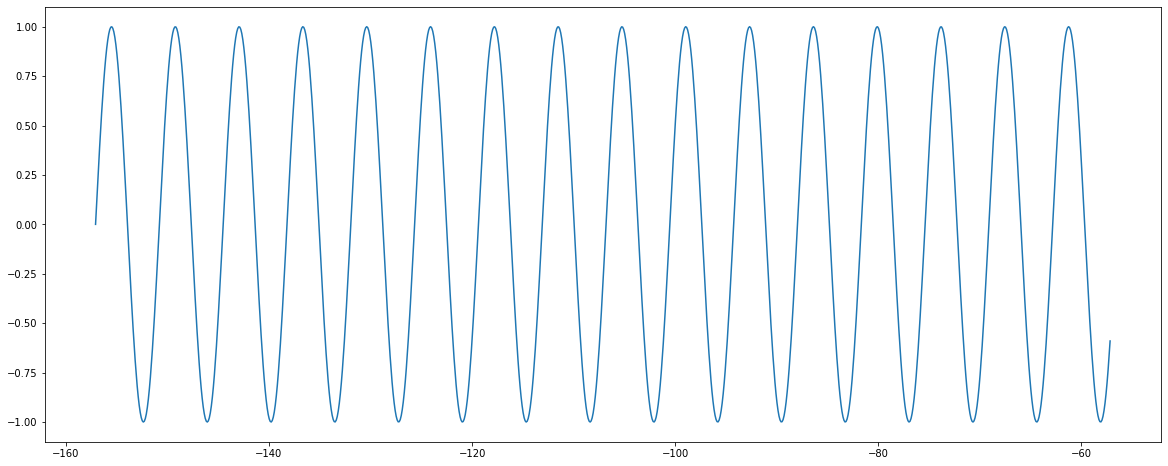

In [7]:
# 取1000 个数据进行可视化
plt.figure(figsize = (20, 8))
plt.plot(xaxis[:1000], sequence_data[:1000])

In [8]:
n_steps = 20
X, y = build_data(sequence_data, n_steps)
X.shape, y.shape

 99%|█████████▉| 3122/3142 [00:00<00:00, 1557955.63it/s]


((3122, 20, 1), (3122,))

### 2. 搭建模型

本模块基于 keras 中的 LSTM、Dense 层搭建时序模型，需要注意以下几点：
1. 选择合适的 hidden size
2. 选择合适的激活函数，比如 relu、tanh
3. 优化器选择 sgd、adam 等等
3. 损失函数选择交叉熵损失函数(cross_entropy) 还是均方误差(mse) 等等 

In [9]:
def create_model():
    """
    Build a LSTM model fit sine/cosine function.
    
    hints: 
        1. a LSTM fit time pattern (ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
        2. a Dense for regression (ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
    """

    model = Sequential()
    model.add(Input(shape = (20, 1)))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(optimizer = 'adam', loss = 'mse')

    return model


In [10]:
# 初始化模型并打印相关信息
model = create_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### 3. 模型训练

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
3122/3122 [==============================] - 4s 1ms/sample - loss: 0.1433
Epoch 2/25
3122/3122 [==============================] - 3s 879us/sample - loss: 0.0072
Epoch 3/25
3122/3122 [==============================] - 3s 881us/sample - loss: 0.0017
Epoch 4/25
3122/3122 [==============================] - 3s 922us/sample - loss: 1.5264e-04
Epoch 5/25
3122/3122 [==============================] - 3s 892us/sample - loss: 8.4090e-05
Epoch 6/25
3122/3122 [==============================] - 3s 895us/sample - loss: 6.3141e-05
Epoch 7/25
3122/3122 [==============================] - 3s 894us/sample - loss: 7.8039e-05
Epoch 8/25
3122/3122 [==============================] - 3s 921us/sample - loss: 6.1336e-05
Epoch 9/25
3122/3122 [==============================] - 3s 895us/sample - loss: 4.2281e-05
Epoch 10/25
3122/3122 [==============================] - 3s 921us/sample - loss: 3.9659e-05
Epoch 11/

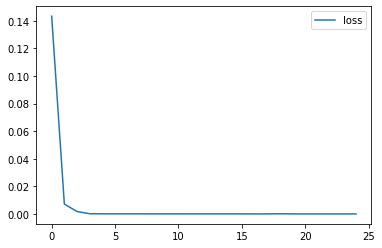

In [12]:
# 尝试更改 epochs ，加入 callbacks，例如 EarlyStopping (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
history = model.fit(X, y, batch_size = 32, epochs = 25, verbose = 1)
plt.plot(history.history['loss'], label='loss')
plt.legend(loc = 'upper right') # 画出损失图像

### 4. 预测

本模块使用和训练数据不同的函数构造测试数据来验证模型的泛化性能，主要有以下几个步骤：
1. 定义新的函数 (sine/cosine)
2. 利用训练好的模型进行预测
3. 将模型预测结果和真实值进行可视化对比

In [13]:
def test_func(x):
    """
    sine/cosine function, different from ground_func above.

    Args:
        x: numpy.ndarray
    return:
        sin(x) or cos(x)
    """
    y = np.cos(x)
    return y

In [21]:
test_xaxis = np.arange(0, 10 * np.pi, 0.1)

test_sequence_data = test_func(test_xaxis)

# 利用初始的 n_steps 个历史数据开始预测，后面的数据依次利用预测出的数据作为历史数据进行进一步预测
y_preds = test_sequence_data[:n_steps]

100%|██████████| 295/295 [00:01<00:00, 183.91it/s]


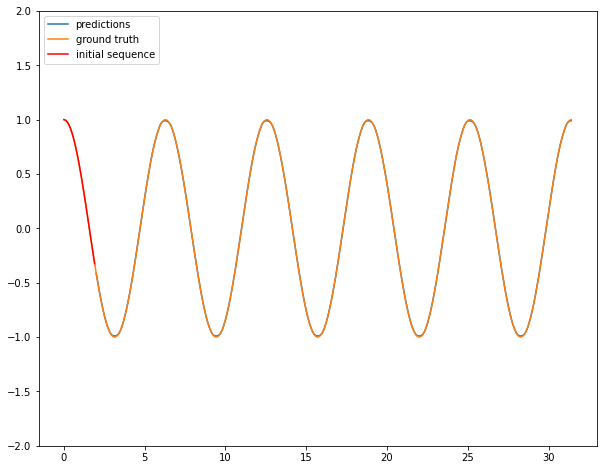

In [24]:
# 逐步预测
for i in tqdm(range(len(test_xaxis) - n_steps)):
    model_input = y_preds[i: i+n_steps]
    model_input = model_input.reshape((1, n_steps, 1))
    y_pred = model.predict(model_input, verbose = 0)
    y_pred = np.append(y_preds, y_pred)

plt.figure(figsize = (10,8))
plt.plot(test_xaxis[n_steps:], y_preds[n_steps:], label = 'predictions')
plt.plot(test_xaxis, test_sequence_data, label = 'ground truth')
plt.plot(test_xaxis[:n_steps], y_preds[:n_steps], label = 'initial sequence', color = 'red')
plt.legend(loc = 'upper left')
plt.ylim(-2,2)
plt.show()